In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statistics

from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FastICA
from scipy.stats import shapiro
from scipy.fftpack import dct
from sklearn.metrics import mean_absolute_error

from google.colab import files
import io

In [ ]:
# upload the dervide data retrieved from computesequences in Matlab
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['derive_data_new.csv']))
data = pd.DataFrame(df)

# Name the column data
data.columns = ['Real Base', 'Base', 'Der 1', 'Der 2', 'Days']
historical_set = 10

Saving derive_data_new.csv to derive_data_new (3).csv


In [ ]:
# Retrieve the DCT data that is used as input from the computesequences file in Matlab
dct_conversion = dct(data['Real Base'].to_numpy(), type=1)

data.insert(4, 'Der 3', dct_conversion)

In [ ]:
# Taking the 3 derivation columns, apply the SVD transformation to the data
derive = data[['Der 1', 'Der 2', 'Der 3']].values

svd = TruncatedSVD(algorithm='arpack')
svd_features = svd.fit_transform(derive)

In [ ]:
gaussian_features = []

# remove columsn that satisfy the gaussian distribution metric and then apply ICA to the remaining data
derive_df = data[['Der 1', 'Der 2', 'Der 3']]
for name, values in derive_df.iteritems():
  # If gaussian distribution, then append feature name to remove later
  if not shapiro(values)[1] < 0.05:
    gaussian_features.append(name)

derive_df = derive_df.drop(columns=gaussian_features)

cpts = 3
ica = FastICA(algorithm='parallel',  
              whiten=True,
              max_iter=cpts,
              fun='exp',
              tol=1E-3)

ica_transform = ica.fit_transform(derive_df.to_numpy())

In [ ]:
# compile transformed data to use as input SVM prediction
for i in range(len(svd_features[0,:])):
  column_name = 'SVD ' + str(i + 1)
  data[column_name] = svd_features[:, i]

for i in range(len(ica_transform[0,:])):
  column_name = 'ICA ' + str(i + 1)
  data[column_name] = ica_transform[:, i]

# After we compile all of the transformed data, we place it into SVM input. Meaning
# this data can now be used as input into predictsvm Matlab file to run the models
print(data)
data.to_csv('SVM_input.csv', encoding='utf-8', index=False, header=False)

      Real Base    Base   Der 1   Der 2          Der 3  Days          SVD 1  \
0          56.0  55.400  169.86  217.76  291050.400000     5  291050.529897   
1          61.0  54.000  165.61  213.00     732.530297     6     732.762253   
2          57.0  55.400  164.59  211.31    1068.640475     0    1068.870620   
3          59.0  61.800  170.32  216.81    -236.672933     1    -236.435539   
4          76.0  64.200  175.20  223.31      55.107287     2      55.351568   
...         ...     ...     ...     ...            ...   ...            ...   
2258       80.0  59.000  173.49  221.41    -621.341933     2    -621.099597   
2259       49.0  59.600  173.73  221.92     835.727120     3     835.969391   
2260       52.0  57.600  171.58  220.33    1879.494814     4    1879.734481   
2261       47.0  56.800  169.39  218.28     239.534067     5     239.771790   
2262       56.0  51.667  162.90  211.69    1070.400000     6    1070.629508   

           SVD 2     ICA 1     ICA 2     ICA 3  
0 

In [3]:
# This section runs the Kingston data that will be used for the histogram nudging

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded['prediction_results_kingston.csv'])) # kingston
# results = pd.DataFrame(df)

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded['amount_kingston_transformed.csv'])) # kingston
# patient_count = pd.DataFrame(df)

# This section runs the Windsor data that will be used for the histogram nudging
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['prediction_results_windsor.csv'])) # windsor
results = pd.DataFrame(df)

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['amount_windsor_transformed.csv'])) # windsor
patient_count = pd.DataFrame(df)

patient_count = patient_count['Count'].to_numpy()

Saving prediction_results_windsor.csv to prediction_results_windsor (1).csv


Saving amount_windsor_transformed.csv to amount_windsor_transformed (1).csv


MAE mean with adjusted values from histogram: 3.885400621393697
MAE mean with adjusted values without histogram: 3.907804527296937


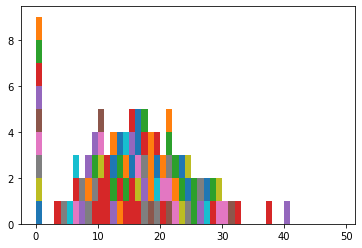

In [4]:
# histogram adjustment
max_patient_count = 30
hist_weight_adj = 0.5
historical_set = 10

assert not results['YHat'].isnull().values.any(), "YHat must not contain empty values"


# This section of the code runs the histogram nudging and then displays the MAE scores of before and after

patien_set = patient_count[:historical_set] # set initial historical data

(n, bins, patches) = plt.hist(patien_set, bins=range(0, max(patien_set) + 2, 1))

hist_adjusted_results = []

# In a for loop, we go through each prediction and then make nudges based on the histogram plot points
for i in range(len(patient_count) - historical_set):
  patien_set = patient_count[i:historical_set + i]
  (n, bins, patches) = plt.hist(patien_set, bins=range(0, max(patien_set) + 10, 1))

  # if the predicted result is greater than all histogram day counts
  if round(results['YHat'][i]) >= len(n):
    hist_adjusted_results.append(results['YHat'][i] - 1)

  # If the prediction has zero accurances in the last 10 days, we go into this statement
  elif n[round(results['YHat'][i])] == 0:
      left = right = round(results['YHat'][i])

      # we determine in which direction the nearest counts are and nudge in that direction
      item = round(results['YHat'][i])
      if item - 1 < 0:
        if item + 1 <= len(n) and n[item + 1] > 0:
          hist_adjusted_results.append(results['YHat'][i] + 1)
        else:
          hist_adjusted_results.append(results['YHat'][i])
      elif item + 1 >= len(n):
        if item - 1 > 0 and n[item - 1] > 0:
          hist_adjusted_results.append(results['YHat'][i] - 1)
        else:
          hist_adjusted_results.append(results['YHat'][i])
      # if prediction is within confines of the histogram, then make nudges based on that
      else:
        # Which ever side is greater, we nudge in that direction when we find our
        # nearest neighbours with values
        if n[item - 1] > n[item + 1]:
          hist_adjusted_results.append(results['YHat'][i] - 1)
        elif n[item - 1] < n[item + 1]:
          hist_adjusted_results.append(results['YHat'][i] + 1)
        else:
          hist_adjusted_results.append(results['YHat'][i])


      
  # If current prediction is less than one of its neighbours, we go into this conditional
  elif n[round(results['YHat'][i])] < n[round(results['YHat'][i]) - 1] or n[round(results['YHat'][i])] < n[round(results['YHat'][i]) + 1]:
    left_diff = abs(n[round(results['YHat'][i])] - n[round(results['YHat'][i]) - 1])
    right_diff = abs(n[round(results['YHat'][i])] - n[round(results['YHat'][i]) + 1])

    # we determine which side is the greater one
    if left_diff >= right_diff:
      # change to neighbour if it meets a certain threshold difference
      if left_diff > 3:
        hist_adjusted_results.append(results['YHat'][i] - 1)
      else:
        hist_adjusted_results.append(results['YHat'][i])
    elif right_diff > left_diff:
      if right_diff > 3:
        hist_adjusted_results.append(results['YHat'][i] + 1)
      else:
        hist_adjusted_results.append(results['YHat'][i])
    else:
      hist_adjusted_results.append(results['YHat'][i])
  else:
    hist_adjusted_results.append(results['YHat'][i])
        

print('MAE mean with adjusted values from histogram: ' + str(mean_absolute_error(results['Label'], hist_adjusted_results)))
print('MAE mean with adjusted values without histogram: ' + str(mean_absolute_error(results['Label'], results['YHat'])))

MAE mean with adjusted values from histogram: 3.83924793608522
MAE mean with adjusted values without histogram: 3.907804527296937


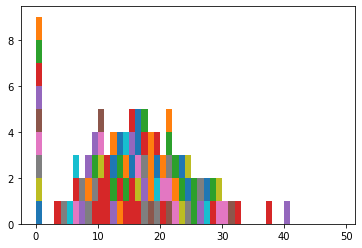

In [5]:
# Alternative solution for histogram nudging

mean_bound_adjust = True

# histogram adjustment
max_patient_count = 30
hist_weight_adj = 0.5
historical_set = 10

assert not results['YHat'].isnull().values.any(), "YHat must not contain empty values"

# derive error of margin dict
margin_err = []
margin_err_dict = {}

for i in range(len(results)):
  diff = abs(results['Label'][i] - results['YHat'][i])
  margin_err.append(diff)

for i in range(len(results)):
  if results['Label'][i] in margin_err_dict:
    margin_err_dict[results['Label'][i]].append(results['YHat'][i] - results['Label'][i])
  else:
    margin_err_dict[results['Label'][i]] = [results['YHat'][i] - results['Label'][i]]


for day, error_list in margin_err_dict.items():
  mean = statistics.mean(error_list)
  margin_err_dict[day] = mean

# get lowest margin of error patient intakes
low_margin = list(filter(lambda x: 0 < margin_err_dict[x] < 1, margin_err_dict))[0]

# set upper and lower bounds around low margin of errors
upper_bound = low_margin + 5
lower_bound = low_margin - 5

patien_set = patient_count[:historical_set] # set initial historical data

(n, bins, patches) = plt.hist(patien_set, bins=range(0, max(patien_set) + 2, 1))

hist_adjusted_results = []

# iterate over each prediction, if value is above or below threshold then we adjust it
for i in range(len(patient_count) - historical_set):
  patien_set = patient_count[i:historical_set + i]
  (n, bins, patches) = plt.hist(patien_set, bins=range(0, max(patien_set) + 10, 1))

  if mean_bound_adjust:
    # if value is too high or low, then it is more likely to be less accurate, therefore we judge it based on the mean of the previous 10 days
    if round(results['YHat'][i]) > upper_bound or round(results['YHat'][i]) < lower_bound:
      mids = 0.5*(bins[1:] + bins[:-1])
      probs = n / np.sum(n)

      mean = np.sum(probs * mids)  
      if round(results['YHat'][i]) > upper_bound:
        if mean + 5 < results['YHat'][i]:
          hist_adjusted_results.append(results['YHat'][i] - 3)
        elif mean < results['YHat'][i]: 
          hist_adjusted_results.append(results['YHat'][i] - 1)
        else:
          hist_adjusted_results.append(results['YHat'][i])

      else:
        if mean + 5 < results['YHat'][i]:
          hist_adjusted_results.append(results['YHat'][i] + 3)
        elif mean < results['YHat'][i]: 
          hist_adjusted_results.append(results['YHat'][i] + 1)
        else:
          hist_adjusted_results.append(results['YHat'][i])

    else:
      hist_adjusted_results.append(results['YHat'][i])

print('MAE mean with adjusted values from histogram: ' + str(mean_absolute_error(results['Label'], hist_adjusted_results)))
print('MAE mean with adjusted values without histogram: ' + str(mean_absolute_error(results['Label'], results['YHat'])))

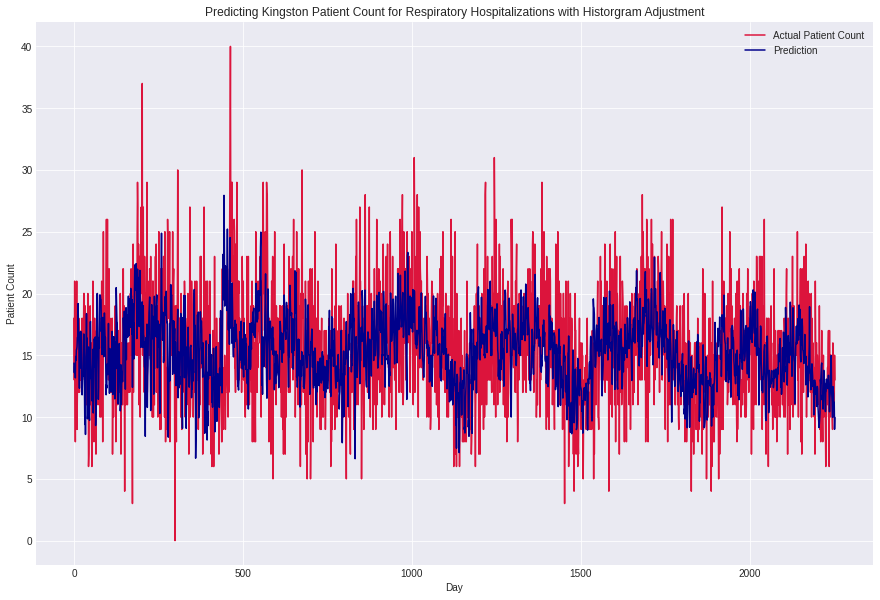

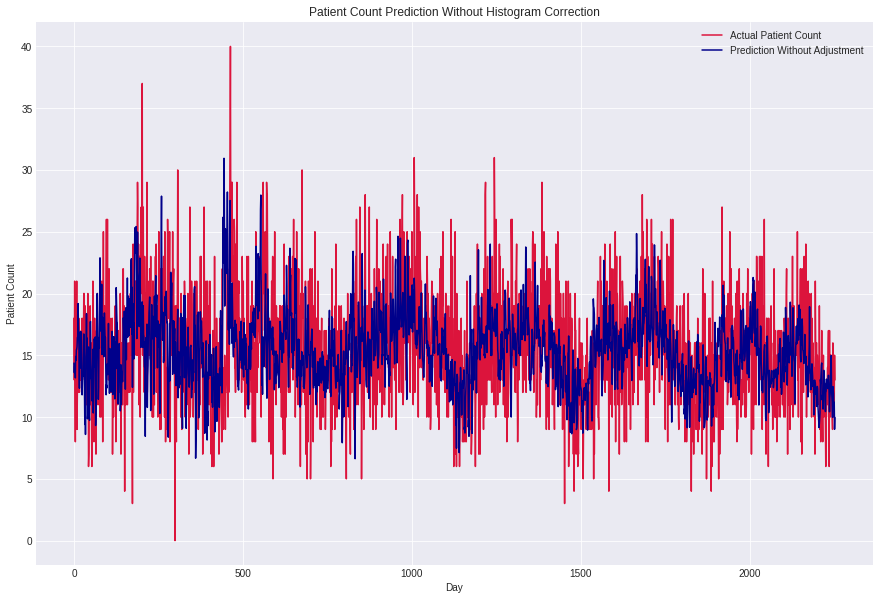

In [6]:
# These two plots display the contrast between the predicted and actual patient counts. It
# displays both with or without histogram adjustments

plt.figure(figsize=(15,10))
plt.style.use(['seaborn-darkgrid'])
plt.plot(results['Label'], color="crimson", label="Actual Patient Count")
plt.plot(hist_adjusted_results, color="darkblue", label="Prediction")

plt.xlabel("Day")
plt.ylabel("Patient Count")
plt.title("Predicting Kingston Patient Count for Respiratory Hospitalizations with Historgram Adjustment")
plt.legend(loc="upper right")

plt.figure(figsize=(15,10))
plt.style.use(['seaborn-darkgrid'])
plt.plot(results['Label'], color="crimson", label="Actual Patient Count")
plt.plot(results['YHat'], color="darkblue", label="Prediction Without Adjustment")

plt.xlabel("Day")
plt.ylabel("Patient Count")
plt.title("Patient Count Prediction Without Histogram Correction")
plt.legend(loc="upper right")


plt.show()

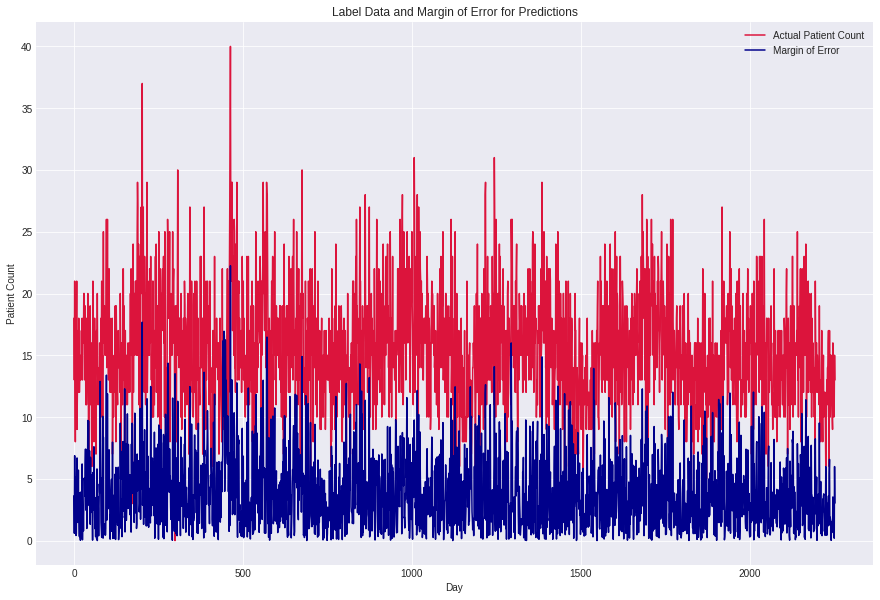

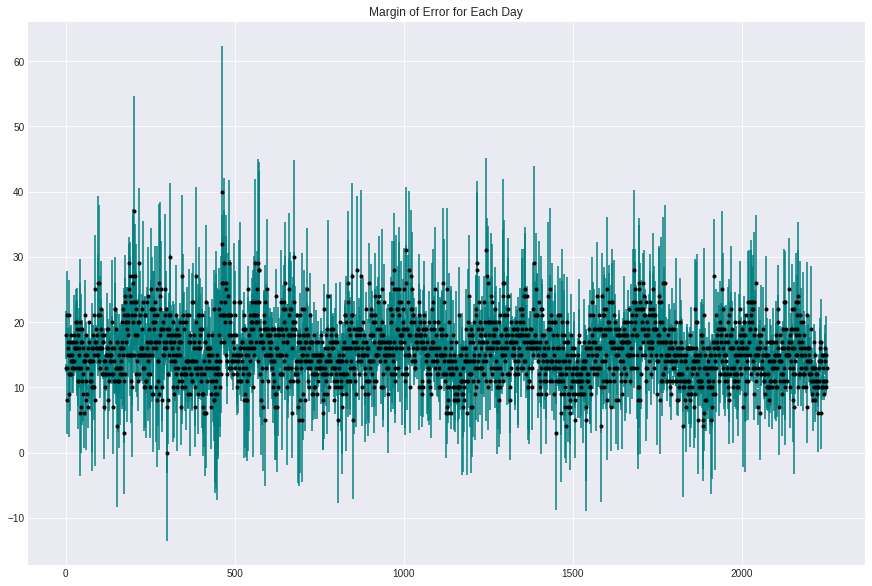

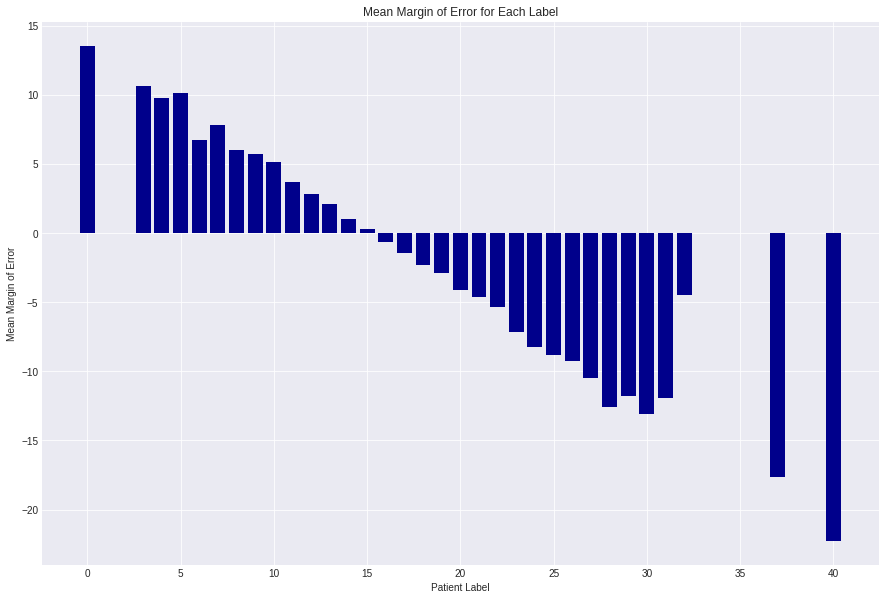

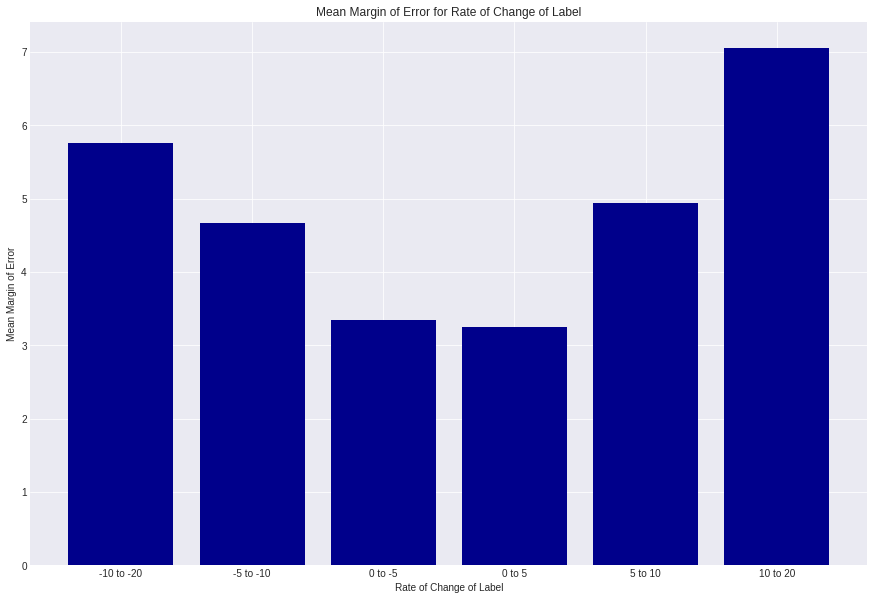

In [8]:
# In this section, I plot multiple graphs that dislay different aspects of how the predictions operate
margin_err = []
margin_err_dict = {}

for i in range(len(results)):
  diff = abs(results['Label'][i] - results['YHat'][i])
  margin_err.append(diff)

for i in range(len(results)):
  if results['Label'][i] in margin_err_dict:
    margin_err_dict[results['Label'][i]].append(results['YHat'][i] - results['Label'][i])
  else:
    margin_err_dict[results['Label'][i]] = [results['YHat'][i] - results['Label'][i]]


for day, error_list in margin_err_dict.items():
  mean = statistics.mean(error_list)
  margin_err_dict[day] = mean

plt.figure(figsize=(15,10))
plt.style.use(['seaborn-darkgrid'])
plt.plot(results['Label'], color="crimson", label="Actual Patient Count")
plt.plot(margin_err, color="darkblue", label="Margin of Error")

# Displays both the label data and the margin of errors on the predicted results without a histogram
plt.xlabel("Day")
plt.ylabel("Patient Count")
plt.title("Label Data and Margin of Error for Predictions")
plt.legend(loc="upper right")


# This next graph displays all of the predictions errors of margin for each day, where
# a line depicts how far off the prediction was from the actual label data point.
days = range(len(results['Label']))
plt.figure(figsize=(15,10))
plt.errorbar(days, results['Label'], yerr=margin_err, fmt='.k', ecolor="teal");
plt.title("Margin of Error for Each Day")

margin_lists = sorted(margin_err_dict.items()) 
count, margin = zip(*margin_lists) 

# Depicts what the mean of all of the margin of errors are for each count (i.e.
# what the mean margin of error is for days with 10 patient intakes, etc)
plt.figure(figsize=(15,10))
plt.title("Mean Margin of Error for Each Label")
plt.bar(count, margin, color="darkblue")
plt.xlabel('Patient Label')
plt.ylabel('Mean Margin of Error')


# The same as above, except it displays the mean margin of error for 
# rate of change between patient intakes
results['Label Change'] = results['Label'].diff()

rate_change_dict = {
    "-10 to -20": [],
    "-5 to -10": [],
    "0 to -5": [],
    "0 to 5": [],
    "5 to 10": [],
    "10 to 20": []
}

for i in range(len(results['Label Change'])):
  label_change = results['Label Change'][i]
  if isinstance(label_change, float):
    if 0 <= label_change <= 5:
      rate_change_dict["0 to 5"].append(margin_err[i])
    elif 5 < label_change <= 10:
      rate_change_dict["5 to 10"].append(margin_err[i])
    elif 10 < label_change:
      rate_change_dict["10 to 20"].append(margin_err[i])
    elif 0 > label_change >= -5:
      rate_change_dict["0 to -5"].append(margin_err[i])
    elif 5 > label_change >= -10:
      rate_change_dict["-5 to -10"].append(margin_err[i])
    else:
      rate_change_dict["-10 to -20"].append(margin_err[i])

rate_margin_err = {}
for rate_change, error_list in rate_change_dict.items():
  mean = statistics.mean(error_list)
  rate_margin_err[rate_change] = mean

# Additional graph for displaying rate of change in connection to margins of error
range_rate, margin = zip(*rate_margin_err.items()) 
plt.figure(figsize=(15,10))
plt.title("Mean Margin of Error for Rate of Change of Label")
plt.bar(range_rate, margin, color="darkblue")
plt.xlabel('Rate of Change of Label')
plt.ylabel('Mean Margin of Error')

plt.show()

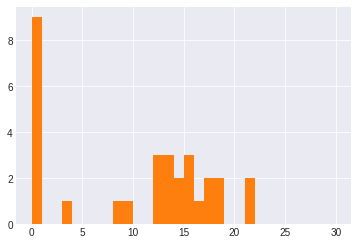

label: 18
yhat:14.368
bin value: 2.0


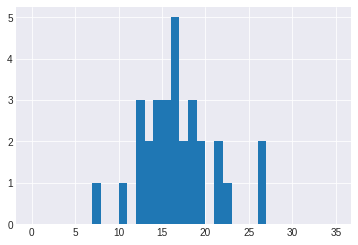

label: 16
yhat:13.443
bin value: 2.0


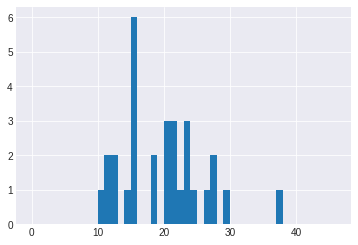

label: 20
yhat:15.788
bin value: 0.0


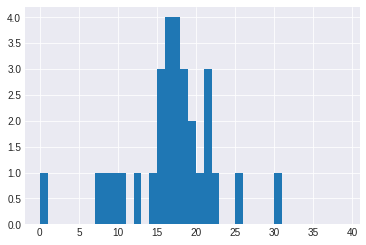

label: 19
yhat:16.069
bin value: 4.0


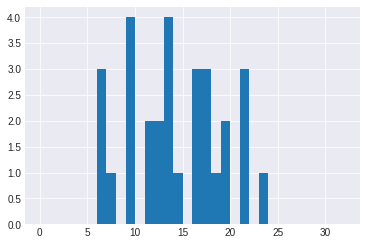

label: 11
yhat:13.889
bin value: 1.0


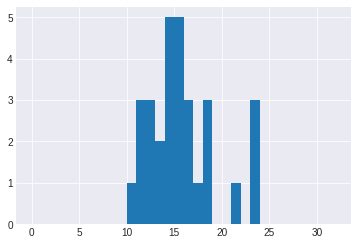

label: 14
yhat:15.135
bin value: 5.0


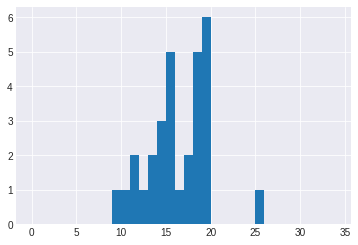

label: 15
yhat:13.648
bin value: 3.0


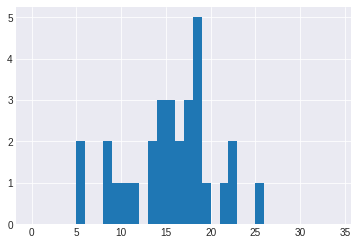

label: 5
yhat:14.553
bin value: 3.0


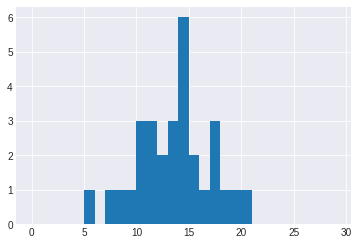

label: 12
yhat:14.097
bin value: 6.0


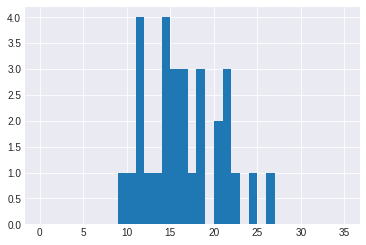

label: 14
yhat:14.335
bin value: 4.0


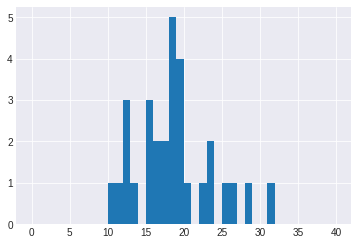

label: 25
yhat:18.693
bin value: 4.0


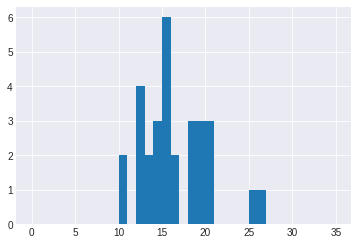

label: 20
yhat:13.87
bin value: 3.0


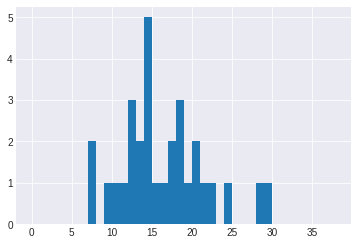

label: 12
yhat:17.424
bin value: 2.0


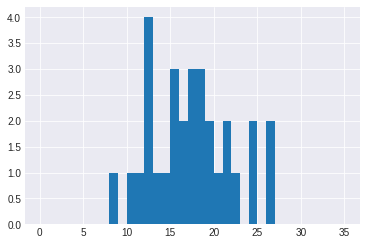

label: 19
yhat:15.648
bin value: 2.0


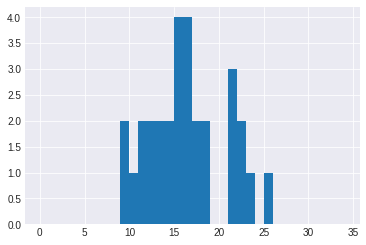

label: 16
yhat:14.926
bin value: 4.0


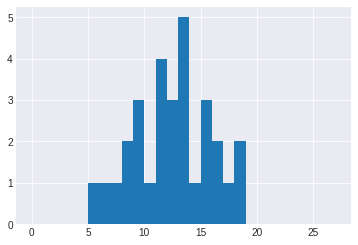

label: 11
yhat:12.38
bin value: 3.0


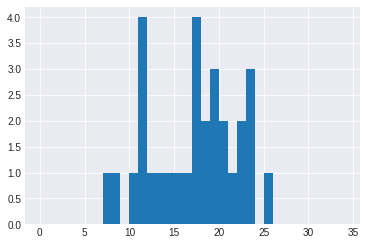

label: 11
yhat:15.395
bin value: 1.0


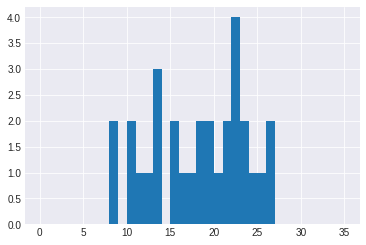

label: 16
yhat:20.555
bin value: 2.0


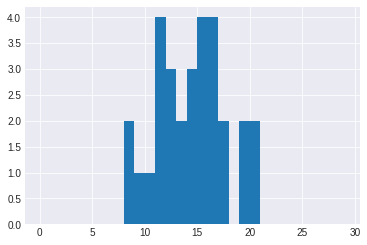

label: 13
yhat:14.497
bin value: 3.0


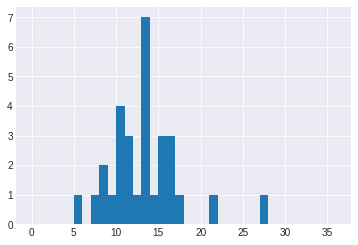

label: 11
yhat:14.707
bin value: 3.0


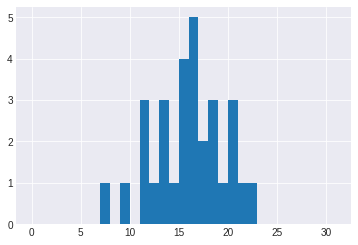

label: 17
yhat:17.292
bin value: 2.0


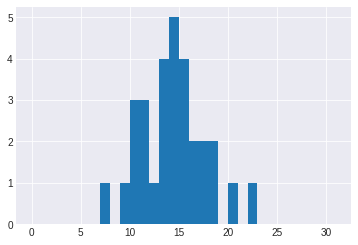

label: 11
yhat:16.868
bin value: 2.0


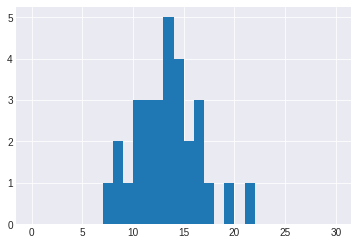

label: 15
yhat:12.477
bin value: 3.0


In [11]:
# This code snippet displays some of the histograms in 30 day periods for visualization purposes

# histogram adjustment
max_patient_count = 30
hist_weight_adj = 0.5
historical_set = 30


patien_set = patient_count[:historical_set] # set initial historical data

(n, bins, patches) = plt.hist(patien_set, bins=range(0, max(patien_set) + 2, 1))

for i in range(len(patient_count) - historical_set):
  if i % 100 == 0:
    patien_set = patient_count[i:historical_set + i]
    (n, bins, patches) = plt.hist(patien_set, bins=range(0, max(patien_set) + 10, 1))
    plt.show()

    print('label: ' + str(results['Label'][i]))
    print('yhat:' + str(results['YHat'][i]))
    print('bin value: ' + str(n[round(results['YHat'][i])]))